In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import LeastSquares
import matplotlib.ticker as ticker

R = 1.1e6
errR=.1e6

data=np.loadtxt("fwhm_ch_900mm2.txt")
V_bias = data[:,0]
V_buio = data[:,1]*1e-3 #in mV
ch = data[:,2]
err_ch = [1]*len(V_bias)
fwhm = data[:,4]
err_fwhm = data[:,5]*15
fwhm_ch= []
err_fwhm_ch = []

I_buio = []
err_vbias=[]
err_vbuio=[]
err_Ibuio=[]

for i in range(len(V_buio)):
    
    I_buio.append(V_buio[i]/R*1e6) #in uA
    err_vbias.append(0.5/100* V_bias[i]*2.5)
    err_vbuio.append(0.5/100*V_buio[i])
    err_Ibuio.append(10.5*(err_vbuio[i]*1/R*1e6 + err_vbuio[i]*errR/R )) #in uA
    fwhm_ch.append(fwhm[i]/ch[i]*10**3)
    err_fwhm_ch.append(fwhm_ch[i]*np.sqrt((err_fwhm[i]/fwhm[i])**2+(err_ch[i]/ch[i])**2))




Vbias con fwhm minima = 20.61443082816475+-


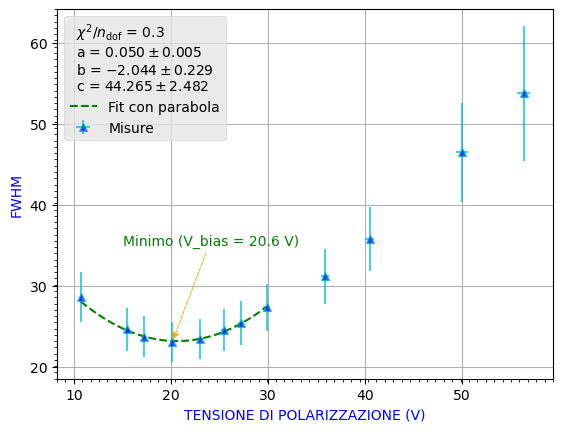

23.205102505165407 5.758852626005158
20.61443082816475 0.251375


In [2]:
#V bias vs fwhm


func1 = lambda x, a, b, c: a*x**2+b*x+c 

least_squares = LeastSquares (V_bias, fwhm, list(map(lambda x: x/10, err_fwhm)), func1)
my_minuit = Minuit (least_squares, a = 0, b = 0, c = 0)
least_squares.mask = (V_bias < 30) & (15 < V_bias)
my_minuit.migrad ()  
my_minuit.hesse ()  
print("Vbias con fwhm minima = " + str(-my_minuit.values[1]/2/my_minuit.values[0]) + "+-" + str())
#display(my_minuit)

x = np.linspace(V_bias[0], V_bias[7], 100)

fig, ax = plt.subplots()
plt.errorbar(V_bias, fwhm, xerr= err_vbias, yerr= list(map(lambda x: x, err_fwhm)), linestyle="None", marker="^", color="k", mec="c", mfc="b", ecolor="c", label="Misure", alpha=.7)
plt.plot(x, func1(x, my_minuit.values[0], my_minuit.values[1], my_minuit.values[2]), linestyle="--", color="g", label="Fit con parabola")
plt.grid("on")
plt.xlabel("TENSIONE DI POLARIZZAZIONE (V)", color="blue")
plt.ylabel("FWHM", color="blue")

plt.style.use("ggplot")

fit_info = [
    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {my_minuit.fmin.reduced_chi2:.1f}",
]
for p, v, e in zip(my_minuit.parameters, my_minuit.values, my_minuit.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.legend(title="\n".join(fit_info), frameon=True)

ax.xaxis.set_minor_locator(ticker.LinearLocator(60))
#ax.xaxis.set_major_locator(ticker.LinearLocator(8))

ax.yaxis.set_minor_locator(ticker.LinearLocator(60))
#ax.yaxis.set_major_locator(ticker.LinearLocator(8))

ax.annotate(f'Minimo (V_bias = {round(-my_minuit.values[1]/2/my_minuit.values[0],1)} V)', xy=(V_bias[3], fwhm[3]),
             xycoords='data',
             xytext=(15, 35.1),
             textcoords='data',
             arrowprops=dict(arrowstyle= '-|>',
                             color='orange',
                             lw=.7,
                             ls='--'),
            color="g"
           )



plt.show()

fwhm_best = func1(V_bias[3], my_minuit.values[0], my_minuit.values[1], my_minuit.values[2])
V_best = -my_minuit.values[1]/2/my_minuit.values[0]
err_V_best = err_vbias[3]
err_fwhm_best = np.sqrt((err_V_best*(2*V_best*my_minuit.values[0]+my_minuit.values[1])**2+(my_minuit.errors[0]*V_best**2)**2+(my_minuit.errors[1]*V_best)**2+(my_minuit.errors[2])**2))

print(fwhm_best, err_fwhm_best)
print(V_best, err_V_best)

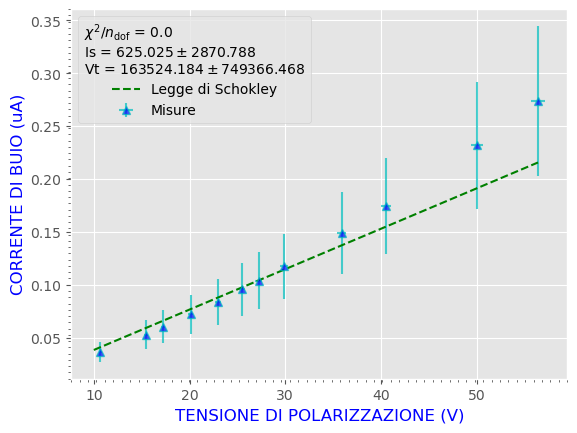

In [3]:

#FIT V bias VS I buio con f(x) = a $x^b$ + c $x^d$


#func1 = lambda x, a, b, c, d: a*x**b + c*x**(-d) #fit exp per V_bias VS I_buio per 900mm2
func2=lambda x, Is, Vt: Is*(1-np.e**(-x/Vt))
#func3 = lambda x, a, b: a*x+b
n=1


err=[]
for i in range(len(V_bias)):
    err.append(10.5*I_buio[i]*np.sqrt((err_Ibuio[i]/I_buio[i])**2+(err_vbias[i]/V_bias[i])**2))


least_squares = LeastSquares (V_bias, I_buio, err[:], func2)
my_minuit = Minuit (least_squares, Is=.3, Vt=40) 
my_minuit.migrad ()  
my_minuit.hesse ()
#display(my_minuit)

x2 = np.linspace(10, V_bias[-1:], 100)

fig, ax = plt.subplots()

plt.errorbar(V_bias, I_buio, xerr= err_vbias, yerr=list(map(lambda x: x*4.5, err_Ibuio)), linestyle="None", marker = "^", color="k", mec="c", mfc="b", ecolor="c", label="Misure", alpha=.7)
plt.plot(x2, func2(x2, my_minuit.values[0], my_minuit.values[1]), linestyle="--", color="g", label="Legge di Schokley")
plt.grid("on")
plt.xlabel("TENSIONE DI POLARIZZAZIONE (V)", color="b")
plt.ylabel("CORRENTE DI BUIO (uA)", color="b")

fit_info = [
    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {my_minuit.fmin.reduced_chi2:.1f}",
]
for p, v, e in zip(my_minuit.parameters, my_minuit.values, my_minuit.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.legend(title="\n".join(fit_info), frameon=True)

plt.style.use("ggplot")

#plt.xlim(10, 80)
#plt.ylim(0.1, 0.26)
# For the x-axis
ax.xaxis.set_minor_locator(ticker.LinearLocator(60))
#ax.xaxis.set_major_locator(ticker.LinearLocator(8))
# For the y-axis
ax.yaxis.set_minor_locator(ticker.LinearLocator(60))
#ax.yaxis.set_major_locator(ticker.LinearLocator(8))



plt.show()



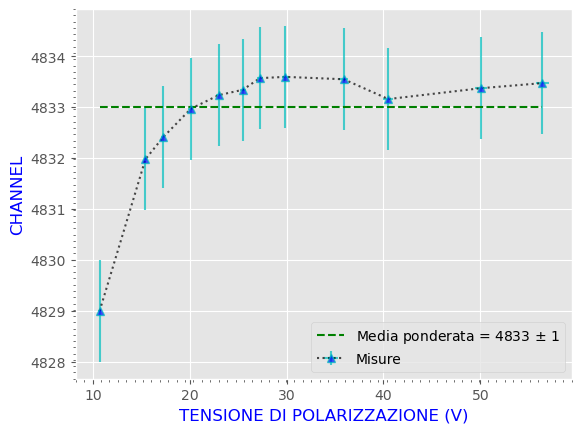

In [4]:

#Plateau Vbias VS channel

fig, ax = plt.subplots()

plt.errorbar(V_bias, ch, xerr=err_vbias, yerr=list(map(lambda x: x, err_ch)), linestyle=":", marker = "^", color="k", mec="c", mfc="b", ecolor="c", label="Misure", alpha=.7)
plt.grid("on")
plt.style.use("ggplot")
plt.xlabel("TENSIONE DI POLARIZZAZIONE (V)", color="b")
plt.ylabel("CHANNEL", color="b")


pesi = list(map(lambda x: 1/x**2, err_ch))
plateau = 0
m = 1 #da che misura calcolo plateau

for i in range(len(ch[m:])):
    plateau = plateau + ch[i+m]*pesi[i+m]

plateau = int(plateau/sum(pesi[m:]))
err_plateau = int(1/np.sqrt(sum(pesi[m:])))

plt.hlines(plateau, V_bias[0], V_bias[-1], linestyle="--", color="g", label=f"Media ponderata = {round(plateau,0)} $\\pm$ {1}")

#plt.xlim(10, 60)
#plt.ylim(round(ch[0], 1), round(ch[-1],1))
# For the x-axis
ax.xaxis.set_minor_locator(ticker.LinearLocator(60))
#ax.xaxis.set_major_locator(ticker.LinearLocator(8))
# For the y-axis
ax.yaxis.set_minor_locator(ticker.LinearLocator(60))
#ax.yaxis.set_major_locator(ticker.LinearLocator(8))


plt.legend(loc = "lower right")
plt.show()


Vbias con fwhm minima = 20.799168820063848


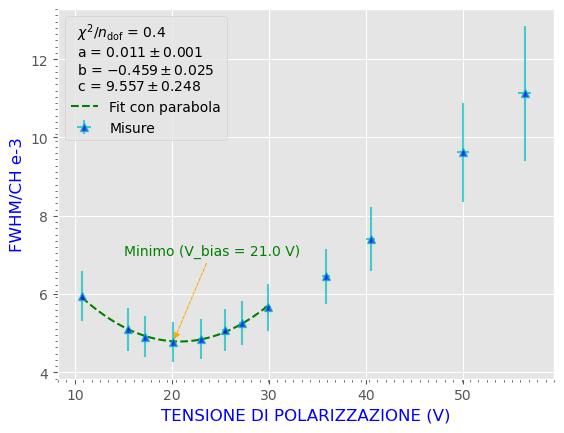

4.793531952457322 0.6330489207529909
20.799168820063848 0.251375


In [5]:
# V bias VS $fwhm/ch$ con f(x) = a$x^2$ + bx + c

func3 = lambda x, a, b, c: a*x**2+b*x+c 

least_squares = LeastSquares (V_bias, fwhm_ch,  list(map(lambda x: x/10, err_fwhm_ch)), func3)
my_minuit = Minuit (least_squares, a = 0, b = 0, c = 0)
least_squares.mask = (V_bias < 30) & (9 < V_bias)
my_minuit.migrad ()  
my_minuit.hesse ()  
print("Vbias con fwhm minima = " + str(-my_minuit.values[1]/2/my_minuit.values[0]) )
#display(my_minuit)

x = np.linspace(V_bias[0], V_bias[7], 100)

fig, ax = plt.subplots()
plt.errorbar(V_bias, fwhm_ch, xerr= err_vbias, yerr= list(map(lambda x: x, err_fwhm_ch)), linestyle="None", marker="^", color="k", mec="c", mfc="b", ecolor="c", label="Misure", alpha=.7)
plt.plot(x, func3(x, my_minuit.values[0], my_minuit.values[1], my_minuit.values[2]), linestyle="--", color="g", label="Fit con parabola")
plt.grid("on")
plt.xlabel("TENSIONE DI POLARIZZAZIONE (V)", color="blue")
plt.ylabel("FWHM/CH e-3", color="blue")

plt.style.use("ggplot")

fit_info = [
    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {my_minuit.fmin.reduced_chi2:.1f}",
]
for p, v, e in zip(my_minuit.parameters, my_minuit.values, my_minuit.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.legend(title="\n".join(fit_info), frameon=True)

ax.xaxis.set_minor_locator(ticker.LinearLocator(60))
#ax.xaxis.set_major_locator(ticker.LinearLocator(8))

ax.yaxis.set_minor_locator(ticker.LinearLocator(60))
#ax.yaxis.set_major_locator(ticker.LinearLocator(8))

ax.annotate(f'Minimo (V_bias = {round(-my_minuit.values[1]/2/my_minuit.values[0],0)} V)', xy=(V_bias[3], fwhm_ch[3]),
             xycoords='data',
             xytext=(15, 7),
             textcoords='data',
             arrowprops=dict(arrowstyle= '-|>',
                             color='orange',
                             lw=.7,
                             ls='--'),
            color="g"
           )

plt.show()

fwhm_ch_best = func3(V_bias[3], my_minuit.values[0], my_minuit.values[1], my_minuit.values[2])
V_ch_best = -my_minuit.values[1]/2/my_minuit.values[0]
err_V_ch_best = err_vbias[3]
err_fwhm_ch_best = np.sqrt((err_V_ch_best*(2*V_ch_best*my_minuit.values[0]+my_minuit.values[1])**2+(my_minuit.errors[0]*V_ch_best**2)**2+(my_minuit.errors[1]*V_ch_best)**2+(my_minuit.errors[2])**2))

print(fwhm_ch_best, err_fwhm_ch_best)
print(V_ch_best, err_V_ch_best)